In [89]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

In [99]:
df_mh = pd.read_excel("res_bal.xlsx")

In [100]:
## 提取待分析的数据
# ACD
X = df_mh[['x1', 'x2', 'x3', 'x4', 'x5', 'x6' ,'x7' ,'x8', 'x9', 'x10', 
        'x11', 'x12', 'x13', 'x14', 'x15', 'cancer history', 'hypertension history', 
        'cholesterol usage', 'stroke_history', 'CVD_history', 'insulin_usage', 'APOE_status', 'sex', 
        'BMI_category', 'Family history of dementia', 'smoking', 'drinking']]
y_ACD = df_mh['ACD']

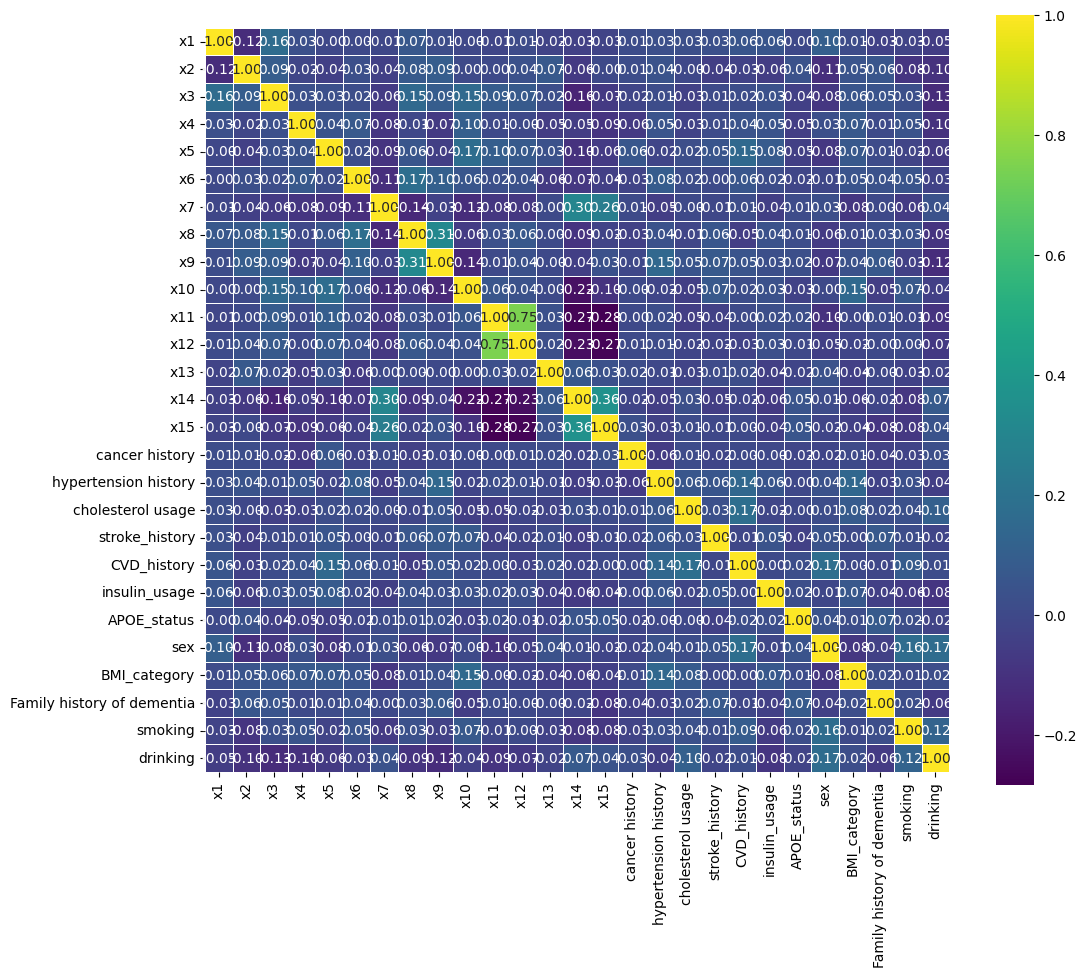

In [9]:
## 相关性矩阵
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X.corr(method='pearson')

# 设置绘图样式
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="viridis", square=True, linewidths=0.5)
plt.show()

In [101]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import pandas as pd

categorical_cols = [col for col in X.columns]

# 预处理器
preprocessor = ColumnTransformer([
    #('num', StandardScaler(), continuous_cols),
    ('cat', 'passthrough', categorical_cols)
])

# 处理 X
X_processed = preprocessor.fit_transform(X)

# 获取列名（sklearn >= 1.0）
feature_names = preprocessor.get_feature_names_out()

# 处理列名（去掉前缀 'num__' 或 'cat__'）
feature_names = [name.split("__")[-1] for name in feature_names]

# 包装成带列名的 DataFrame
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

print(X_processed_df.head())


   x1  x2  x3  x4  x5  x6  x7  x8  x9  x10  ...  cholesterol usage  \
0   0   1   0   0   1   1   0   0   0    1  ...                  0   
1   1   1   0   1   1   1   0   1   1    0  ...                  1   
2   0   1   0   1   1   1   0   1   1    1  ...                  1   
3   0   0   0   0   0   1   0   1   1    0  ...                  1   
4   0   0   0   0   1   1   0   1   1    1  ...                  1   

   stroke_history  CVD_history  insulin_usage  APOE_status  sex  BMI_category  \
0               0            0              0            1    1             3   
1               0            0              0            0    0             4   
2               0            0              0            0    0             4   
3               0            0              1            1    1             4   
4               0            1              0            1    1             4   

   Family history of dementia  smoking  drinking  
0                           0        1   

In [102]:
## 分割数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y_ACD, 
    test_size=0.2,        
    random_state=23333,
    shuffle=True
)

In [ ]:
# ## SMOTE过采样处理类别不平衡问题
# # 初始化 SMOTE 对象
# sm = SMOTE(random_state=42)

# # 对训练集进行重采样
# X_train, y_train = sm.fit_resample(X_train_raw, y_train_raw)

d:\Anaconda\envs\ML\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


特征选择

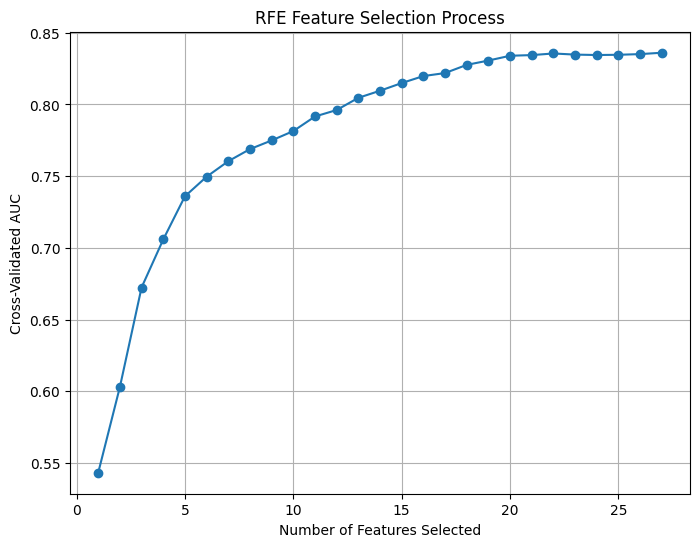

In [10]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

# 基础模型
estimator = LogisticRegression(solver='liblinear', penalty='l2', random_state=42)

# RFECV 自动选择最佳特征数量，使用 AUC 作为评估指标
rfecv = RFECV(
    estimator=estimator,
    step=1,
    cv=StratifiedKFold(5),
    scoring='roc_auc'
)

# 拟合（注意使用的是 SMOTE 后的训练集）
rfecv.fit(X_train, y_train)

# 可视化：特征数量 vs AUC
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
         rfecv.cv_results_['mean_test_score'], marker='o')

plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validated AUC")
plt.title("RFE Feature Selection Process")
plt.grid(True)
plt.show()


In [11]:
from sklearn.feature_selection import RFE

# 使用 RFE 固定选20个特征
rfe = RFE(estimator=estimator, n_features_to_select=20, step=1)
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_].tolist()

# 变换数据
X_train_sel = rfe.transform(X_train)
X_test_sel = rfe.transform(X_test)

## 保留smote前的train
X_train_raw_sel = rfe.transform(X_train_raw)

print("🎯 手动选择的20个特征:", selected_features)

🎯 手动选择的20个特征: ['x1', 'x2', 'x3', 'x4', 'x5', 'x7', 'x8', 'x10', 'x11', 'x13', 'x14', 'x15', 'cancer history', 'hypertension history', 'stroke_history', 'insulin_usage', 'sex', 'Family history of dementia', 'smoking', 'drinking']


将筛选后的特征纳入到多模型里面进行训练，然后评估

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import catboost as cb

models = {
    "SVM": SVC(
        probability=True,  # important for ROC curve
        random_state=42
    ),

    "Logistic Regression": LogisticRegression(
        tol=0.0006199,
        C=0.212116,
        fit_intercept=True,
        class_weight=None,
        random_state=42
    ),

    "Gradient Boosting": GradientBoostingClassifier(
        random_state=42
    ),

    "XGBoost": xgb.XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    ),

    "LightGBM": lgb.LGBMClassifier(
        random_state=42,
        force_row_wise=True
    ),

    "CatBoost": cb.CatBoostClassifier(
        verbose=0,
        random_state=42
    ),
    "AdaBoost": AdaBoostClassifier(
        random_state=42,
        n_estimators=200,
        learning_rate = 1,
        estimator=DecisionTreeClassifier(max_depth=3)
    )
}

NameError: name 'X_train' is not defined

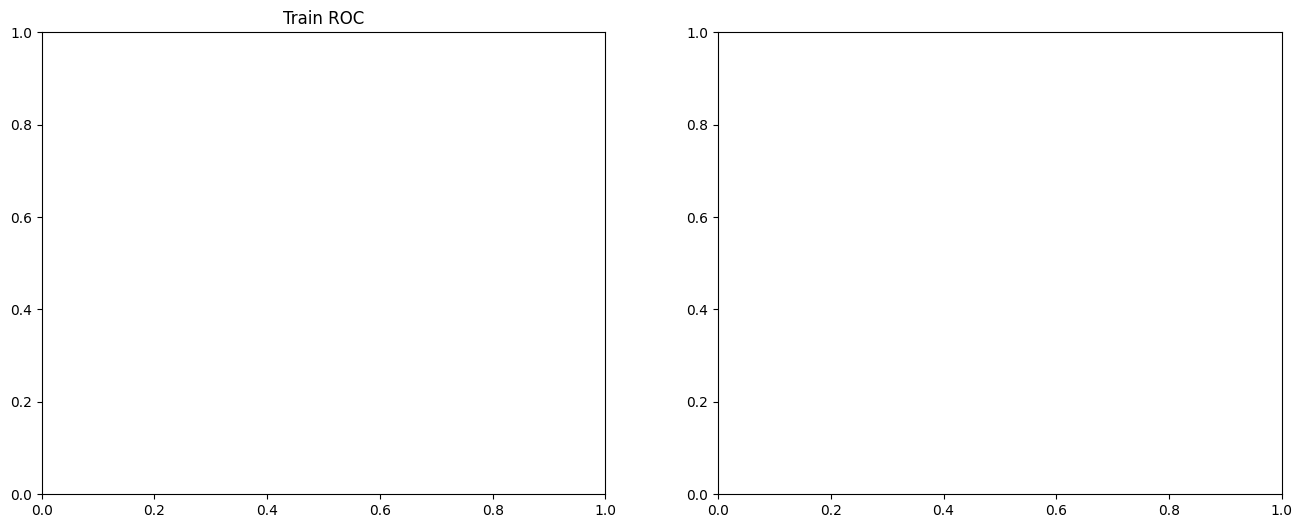

In [2]:
## 绘制5折交叉验证后的训练集ROC与测试集ROC
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# 五折交叉验证对象
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 创建子图
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ------------------- 子图1：训练集 ROC（交叉验证） -------------------
axes[0].set_title('Train ROC')
for model_name, model in models.items():
    y_cv_pred_prob = cross_val_predict(
        model, X_train, y_train, cv=cv,
        method='predict_proba', n_jobs=-1
    )[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_cv_pred_prob)
    auc_train = roc_auc_score(y_train, y_cv_pred_prob)
    axes[0].plot(fpr_train, tpr_train, label=f'{model_name} (AUC = {auc_train:.2f})')

axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend(loc='lower right')
axes[0].grid(True)

# ------------------- 子图2：测试集 ROC -------------------
axes[1].set_title('Test ROC')
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)
    auc_test = roc_auc_score(y_test, y_test_pred_prob)
    axes[1].plot(fpr_test, tpr_test, label=f'{model_name} (AUC = {auc_test:.2f})')

axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend(loc='lower right')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [105]:
## 调参前的模型指标
## 生成模型的统计指标
compare_results1 = ['model_name','dataset', 'TN','FP','FN','TP','Pre','Rec','F0.5','F1',
                   'F2','AP','ROC_AUC','AUCPR','Brier','ACC']

from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    average_precision_score,
    balanced_accuracy_score,
    mean_absolute_error,
    precision_recall_curve,
    auc,
    cohen_kappa_score,
    confusion_matrix,
    fbeta_score,
    precision_recall_fscore_support,
    roc_curve,
    brier_score_loss,
    accuracy_score
)
for i in models.keys():
    print(i)
    if i == 'Tab':
        y_train = y_train.values
        y_test = y_test.values
        x_train = X_train.values
        x_test = X_test.values

    model = models[i]
    model.fit(X_train, y_train)
    # test set
    y_pred = model.predict(X_test)
    y_pred_1_proba = model.predict_proba(X_test)[:, 1]
    y_pred_proba = model.predict_proba(X_test)
    tn, fp, fn, tp  = confusion_matrix(y_test, y_pred_proba.argmax(axis=1)).ravel()
    f2 = fbeta_score(y_test, y_pred, average='binary', beta=2)
    f0_5 = fbeta_score(y_test, y_pred, average='binary', beta=0.5)
    f1 = f1_score(y_test, y_pred, average='binary')
    precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    ROC_AUC = roc_auc_score(y_test, y_pred_1_proba, average='weighted')
    (precisions, recalls, _) = precision_recall_curve(y_test, y_pred_1_proba)
    aucpr = auc(recalls, precisions)
    AP = average_precision_score(y_test, y_pred)
    
    brier = brier_score_loss(y_test, y_pred_1_proba)
    acc = accuracy_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    compare_results1 = np.row_stack((compare_results1,[i, 'test', tn, fp, fn, tp, precision, recall, 
                                   f0_5, f1, f2, AP, ROC_AUC, aucpr, brier, acc]))

SVM
Logistic Regression
Gradient Boosting
XGBoost


d:\Anaconda\envs\ML\lib\site-packages\xgboost\core.py:158: UserWarning: [11:33:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 564, number of negative: 686
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 1250, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451200 -> initscore=-0.195823
[LightGBM] [Info] Start training from score -0.195823
CatBoost
AdaBoost


In [106]:
print(compare_results1)

[['model_name' 'dataset' 'TN' 'FP' 'FN' 'TP' 'Pre' 'Rec' 'F0.5' 'F1' 'F2'
  'AP' 'ROC_AUC' 'AUCPR' 'Brier' 'ACC']
 ['SVM' 'test' '114' '55' '55' '89' '0.6' '0.6458333333333334'
  '0.6086387434554974' '0.6220735785953178' '0.6361149110807114'
  '0.5504392971246006' '0.712257560815253' '0.6310338342180876'
  '0.21477640712878598' '0.6389776357827476']
 ['Logistic Regression' 'test' '106' '63' '67' '77' '0.55'
  '0.5347222222222222' '0.546875' '0.5422535211267606'
  '0.5377094972067039' '0.5081547302094427' '0.6541748849441157'
  '0.5737440611851232' '0.2324065349259407' '0.5846645367412141']
 ['Gradient Boosting' 'test' '104' '65' '46' '98' '0.6012269938650306'
  '0.6805555555555556' '0.6155778894472361' '0.6384364820846905'
  '0.6630581867388363' '0.5561332270548445' '0.7374260355029585'
  '0.6528487628776483' '0.1995142976258785' '0.645367412140575']
 ['XGBoost' 'test' '127' '42' '3' '141' '0.7704918032786885'
  '0.9791666666666666' '0.8047945205479452' '0.8623853211009175'
  '0.928853

d:\Anaconda\envs\ML\lib\site-packages\xgboost\core.py:158: UserWarning: [11:59:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 564, number of negative: 686
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 1250, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451200 -> initscore=-0.195823
[LightGBM] [Info] Start training from score -0.195823


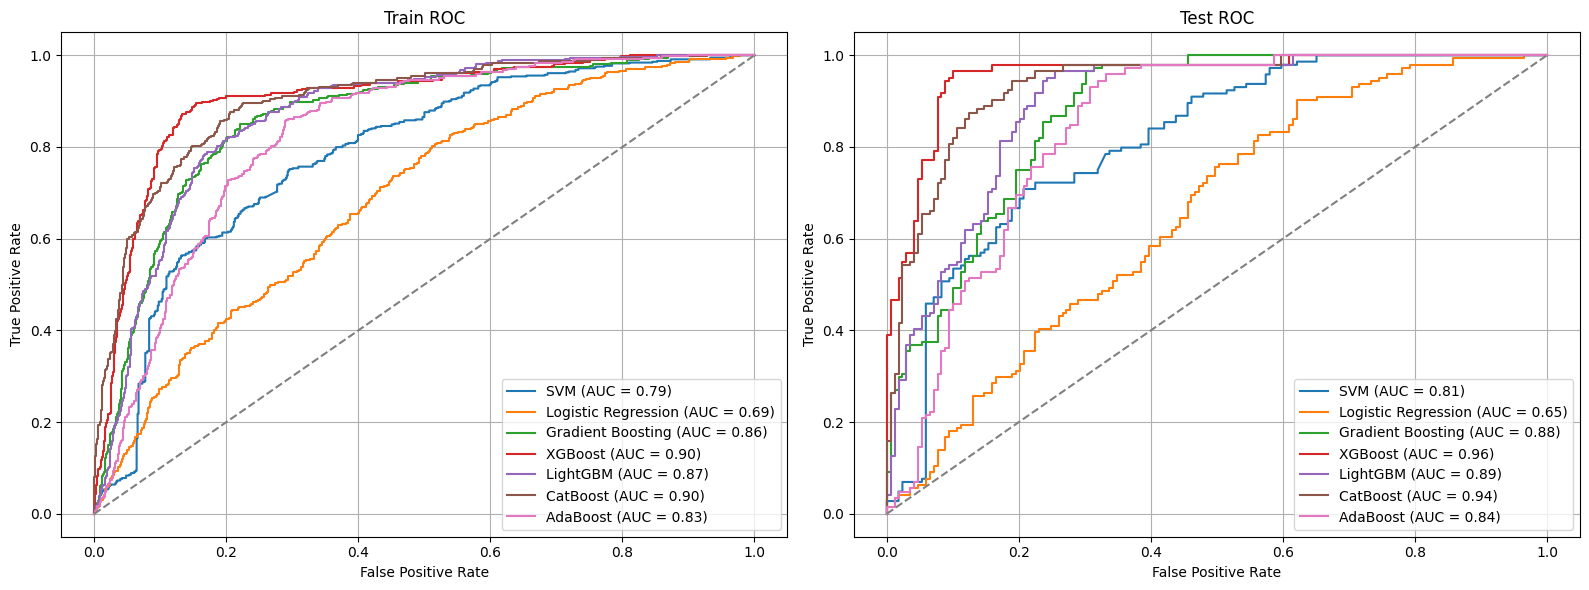

In [130]:
## optuna调参
# 设定先前调参结果
models_new = {
    "SVM": SVC(
        probability=True,  # important for ROC curve
        C=10,
        kernel='rbf',  # 使用径向基函数核
        gamma='scale',  # 'scale' 是默认值，适用于大多数情况
        random_state=42
    ),

    "Logistic Regression": LogisticRegression(
        solver="liblinear",  # 更适合小数据集或稀疏数据
        C = 10,
        penalty='l2',
        class_weight='balanced',
        random_state=42
    ),

    "Gradient Boosting": GradientBoostingClassifier(
        max_depth=4,
        n_estimators=200,
        random_state=42
    ),

    "XGBoost": xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=7,
    n_estimators=200,
    scale_pos_weight=1,
    subsample=1.0
),

    "LightGBM": lgb.LGBMClassifier(
        random_state=42,
        force_row_wise=True
    ),

    "CatBoost": cb.CatBoostClassifier(
        verbose=0,
        random_state=42
    ),
    "AdaBoost": AdaBoostClassifier(
        random_state=42,
        n_estimators=200,
        learning_rate = 1,
        estimator=DecisionTreeClassifier(max_depth=3)
    )
}

## 绘制5折交叉验证后的训练集ROC与测试集ROC
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# 五折交叉验证对象
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 创建子图
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ------------------- 子图1：训练集 ROC（交叉验证） -------------------
axes[0].set_title('Train ROC')
for model_name, model in models_new.items():
    y_cv_pred_prob = cross_val_predict(
        model, X_train, y_train, cv=cv,
        method='predict_proba', n_jobs=-1
    )[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_cv_pred_prob)
    auc_train = roc_auc_score(y_train, y_cv_pred_prob)
    axes[0].plot(fpr_train, tpr_train, label=f'{model_name} (AUC = {auc_train:.2f})')

axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend(loc='lower right')
axes[0].grid(True)

# ------------------- 子图2：测试集 ROC -------------------
axes[1].set_title('Test ROC')
for model_name, model in models_new.items():
    model.fit(X_train, y_train)
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)
    auc_test = roc_auc_score(y_test, y_test_pred_prob)
    axes[1].plot(fpr_test, tpr_test, label=f'{model_name} (AUC = {auc_test:.2f})')

axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend(loc='lower right')
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [78]:
## 生成模型的统计指标
compare_results = ['model_name','dataset', 'TN','FP','FN','TP','Pre','Rec','F0.5','F1',
                   'F2','AP','ROC_AUC','AUCPR','Brier','ACC']

from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    average_precision_score,
    balanced_accuracy_score,
    mean_absolute_error,
    precision_recall_curve,
    auc,
    cohen_kappa_score,
    confusion_matrix,
    fbeta_score,
    precision_recall_fscore_support,
    roc_curve,
    brier_score_loss,
    accuracy_score
)
for i in models_new.keys():
    print(i)
    if i == 'Tab':
        y_train = y_train.values
        y_test = y_test.values
        x_train = X_train.values
        x_test = X_test.values

    model = models_new[i]
    model.fit(X_train, y_train)
    # test set
    y_pred = model.predict(X_test)
    y_pred_1_proba = model.predict_proba(X_test)[:, 1]
    y_pred_proba = model.predict_proba(X_test)
    tn, fp, fn, tp  = confusion_matrix(y_test, y_pred_proba.argmax(axis=1)).ravel()
    f2 = fbeta_score(y_test, y_pred, average='binary', beta=2)
    f0_5 = fbeta_score(y_test, y_pred, average='binary', beta=0.5)
    f1 = f1_score(y_test, y_pred, average='binary')
    precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    ROC_AUC = roc_auc_score(y_test, y_pred_1_proba, average='weighted')
    (precisions, recalls, _) = precision_recall_curve(y_test, y_pred_1_proba)
    aucpr = auc(recalls, precisions)
    AP = average_precision_score(y_test, y_pred)
    
    brier = brier_score_loss(y_test, y_pred_1_proba)
    acc = accuracy_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    compare_results = np.row_stack((compare_results,[i, 'test', tn, fp, fn, tp, precision, recall, 
                                   f0_5, f1, f2, AP, ROC_AUC, aucpr, brier, acc]))

SVM
Logistic Regression
Gradient Boosting
XGBoost


d:\Anaconda\envs\ML\lib\site-packages\xgboost\core.py:158: UserWarning: [11:09:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 564, number of negative: 686
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 1250, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451200 -> initscore=-0.195823
[LightGBM] [Info] Start training from score -0.195823
CatBoost


In [79]:
print(compare_results)

[['model_name' 'dataset' 'TN' 'FP' 'FN' 'TP' 'Pre' 'Rec' 'F0.5' 'F1' 'F2'
  'AP' 'ROC_AUC' 'AUCPR' 'Brier' 'ACC']
 ['SVM' 'test' '115' '54' '36' '108' '0.6358695652173914' '0.8125'
  '0.6647727272727273' '0.7134146341463414' '0.7697368421052632'
  '0.6029060025698014' '0.8134861932938855' '0.7313681235872689'
  '0.17699603067112996' '0.6996805111821086']
 ['Logistic Regression' 'test' '94' '75' '52' '92' '0.5508982035928144'
  '0.6388888888888888' '0.5665024630541872' '0.5916398713826366'
  '0.6191117092866757' '0.5180969264878125' '0.6526134122287968'
  '0.567776777157309' '0.23474500257056313' '0.5942492012779552']
 ['Gradient Boosting' 'test' '143' '26' '3' '141' '0.844311377245509'
  '0.9791666666666666' '0.8682266009852216' '0.9067524115755627'
  '0.9488559892328399' '0.8363062214229687' '0.9829470742932283'
  '0.9849918645298723' '0.0822385613940461' '0.9073482428115016']
 ['XGBoost' 'test' '126' '43' '3' '141' '0.7663043478260869'
  '0.9791666666666666' '0.8011363636363636' '0.8

In [108]:
## 选择xgbooost进行SHAP解释
import shap
import matplotlib.pyplot as plt
import numpy as np
import copy

## shap
model_best = models_new['XGBoost']
model_best.fit(X_train, y_train) ## 补充  

# # 取一小部分训练集作为 background + explanation set
# background = shap.utils.sample(X_train_sel, 200, random_state=0)
# X_explain = shap.utils.sample(X_train_sel, 400, random_state=1)

# ## 试试用test来解释
# #X_explain = shap.utils.sample(X_test_sel, 300, random_state=1)

# # 定义可调用函数
# def model_predict(x):
#     return model_best.predict_proba(x)[:, 1]

# # 用 KernelExplainer 包裹
# explainer = shap.KernelExplainer(model_predict, background)
# shap_values = explainer.shap_values(X_explain, nsamples=100)

explainer = shap.Explainer(model_best)
shap_values = explainer(X_train)



d:\Anaconda\envs\ML\lib\site-packages\xgboost\core.py:158: UserWarning: [11:35:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [115]:
new_column_names = [
    'Social support',              # x1
    'Social isolation',            # x2
    'Household size',             # x3
    'Social activities',           # x4
    'Life events',                 # x5
    'Educational level',           # x6
    'Education quality',           # x7
    'Household income',            # x8
    'Employment status',           # x9
    'Housing stability',           # x10
    'Natural environment',         # x11
    'Greenspace',                  # x12
    'Bluespace',                   # x13
    'TDI',                         # x14
    'Crime and violence',          # x15
    'cancer history',
    'hypertension history',
    'cholesterol usage',
    'stroke_history',
    'CVD_history',
    'insulin_usage',
    'APOE_status',
    'sex',
    'BMI_category',
    'Family history of dementia',
    'smoking',
    'drinking'
]


In [123]:
X_train_selected = X_train.copy()

## 替换列名
X_train_selected.columns = new_column_names
X_train.columns = new_column_names
X_test.columns = new_column_names

In [119]:
explainer = shap.Explainer(model_best, X_train_selected)
shap_values = explainer(X_train_selected)
#shap_values.feature_names = selected_cols
shap.plots.bar(shap_values, max_display=len(X_train.columns), show=False)

fig = plt.gcf()  # ✅ 获取当前的 figure
fig.savefig('SHAP_result/Summary_bar_XGB_new.png', dpi=600, bbox_inches='tight')
plt.close(fig)


 98%|===================| 1219/1250 [00:27<00:00]        

In [120]:
import matplotlib.pyplot as plt

shap.plots.beeswarm(shap_values, color = plt.get_cmap("Spectral"), plot_size=(7, 9), show=False, max_display=len(X_train.columns))
fig1 = plt.gcf()
plt.savefig('SHAP_result/Summary_ori_XGB_new.png', dpi=600, bbox_inches='tight')
plt.close(fig1)

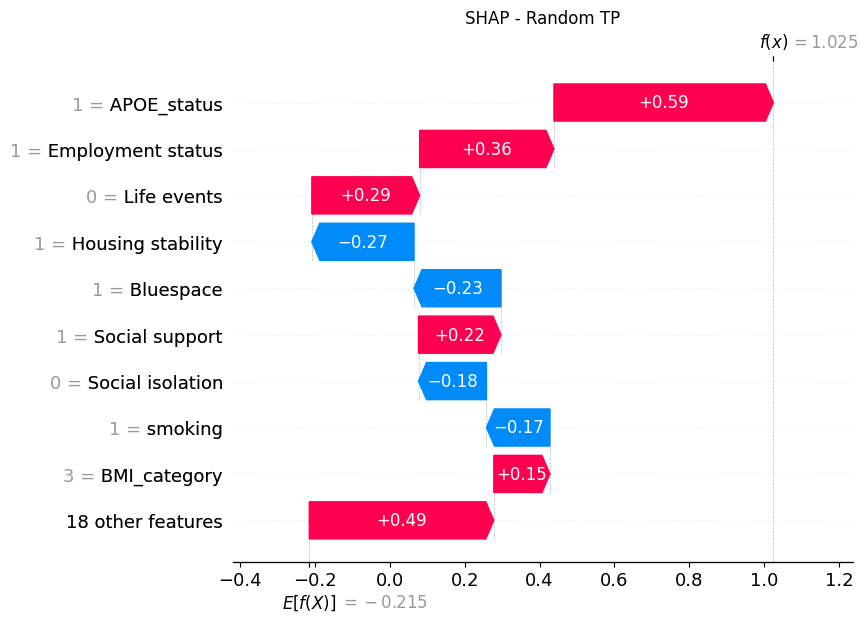

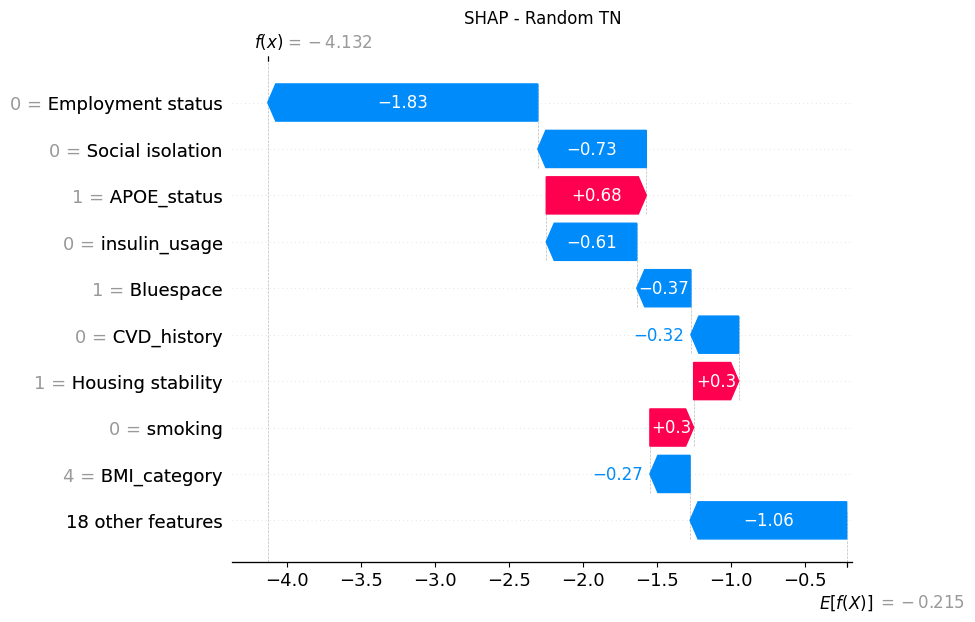

In [126]:
def explain_random_tp_tn(model, X_test, y_test, class_type="TP", save_path_prefix="SHAP_result", random_state=23):
    """
    随机抽取一个 TP 或 TN 样本进行 SHAP waterfall 解释
    class_type: "TP" 或 "TN"
    """
    # 预测
    y_pred = model.predict(X_test)
    X_test_df = pd.DataFrame(X_test).reset_index(drop=True)
    y_test_series = pd.Series(y_test).reset_index(drop=True)

    # 筛选 TP 或 TN
    if class_type.upper() == "TP":
        candidates = X_test_df[(y_test_series == 1) & (y_pred == 1)]
    elif class_type.upper() == "TN":
        candidates = X_test_df[(y_test_series == 0) & (y_pred == 0)]
    else:
        raise ValueError("class_type must be 'TP' or 'TN'")

    # 随机抽取一个样本
    instance = candidates.sample(1, random_state=random_state)
    
    # SHAP解释器
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(instance)

    # 可视化
    shap.plots.waterfall(shap_values[0], show=False)
    save_path = f"{save_path_prefix}/Waterfall_{class_type}_random.png"
    plt.title(f"SHAP - Random {class_type}")
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()

    return shap_values[0]  # 可返回该样本信息


# 解释一个随机 TP 样本
shap_tp = explain_random_tp_tn(models_new["XGBoost"], X_test, y_test, class_type="TP")

# 解释一个随机 TN 样本
shap_tn = explain_random_tp_tn(models_new["XGBoost"], X_test, y_test, class_type="TN")

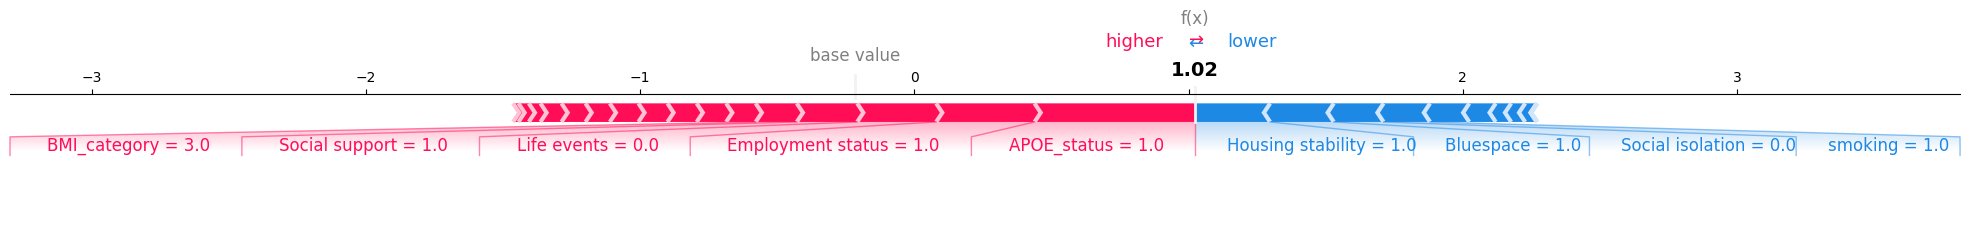

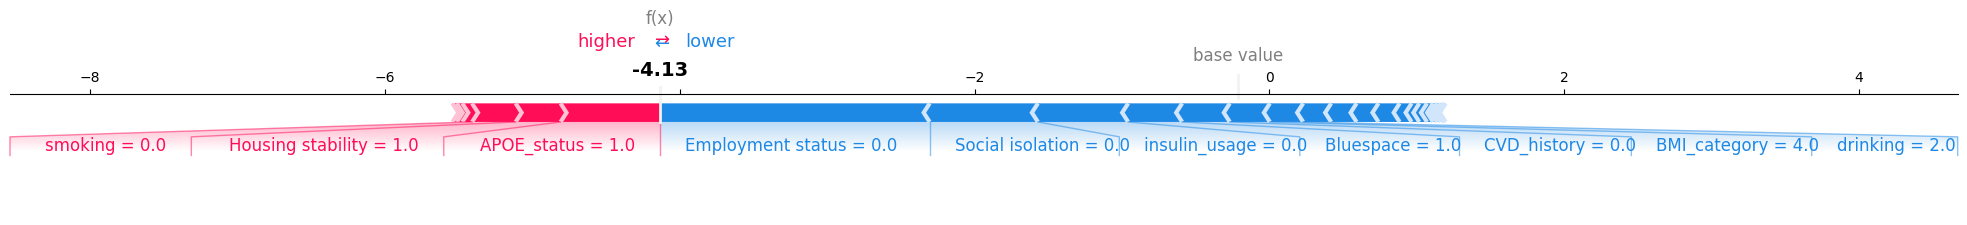

In [127]:
# === 🧠 力图解释函数：从解释结果中生成 force_plot 可视化 ===
def draw_force_plot(shap_exp, title=None, save_path=None):
    # 注意 force_plot 要用老 API shap.force_plot（返回 HTML），不是 shap.plots.force（返回 matplotlib 图）
    force_html = shap.force_plot(
        base_value=shap_exp.base_values,
        shap_values=shap_exp.values,
        features=shap_exp.data,
        feature_names=shap_exp.feature_names,
        matplotlib=True,  # 设置为 True 表示画成 matplotlib 图像而不是 HTML
        show=False
    )
    ax = plt.gca()
    for txt in ax.texts:
        if "f(x)" in txt.get_text():  # 找到预测值文本
            txt.set_position((txt.get_position()[0], txt.get_position()[1] + 0.2))  # 上移一点
    # 可视化 + 保存
    plt.title(title, fontsize=7)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()

# === 📊 TP 力图 ===
draw_force_plot(
    shap_tp,
    #title="SHAP Force Plot - True Positive",
    save_path="SHAP_result/TP_instance_force_new.png"
)

# === 📊 TN 力图 ===
draw_force_plot(
    shap_tn,
    #title="SHAP Force Plot - True Negative",
    save_path="SHAP_result/TN_instance_force_new.png"
)


In [141]:
# 生成热图
shap.plots.heatmap(shap_values, cmap='PiYG', show=False, max_display=len(X_train.columns))

# 获取当前图像对象
fig = plt.gcf()
fig.set_size_inches(15, 25)  # 确保图像大小正确

# 保存图像
fig.savefig("SHAP_result/heatmap_new.png", dpi=600, bbox_inches='tight')

# 关闭图像
plt.close(fig)


In [132]:
## LR coefficient
# nomogram
X_train_sel = X_train.copy()


LR_model = models_new['Logistic Regression']
nomo_list = ['name', 'coef', 'min',	'max']
intercept = LR_model.intercept_[0]
threshold = 0.5

for var in range(X_train_sel.shape[1]):
    nomo_list = np.row_stack((nomo_list, [X_train_sel.columns[var],
                                          LR_model.coef_[0][var],
                                          X_train_sel[X_train_sel.columns[var]].min(),
                                          X_train_sel[X_train_sel.columns[var]].max()]
                                                 ))
nomo_list = pd.DataFrame(nomo_list[1:,:], columns=nomo_list[0,:])
nomo_list['coef'] = pd.to_numeric(nomo_list['coef'])
nomo_list['abs_values'] = nomo_list['coef'].abs()
nomo_list_sorted = nomo_list.sort_values(by='abs_values', ascending=False)

# 构造与 nomo_list_sorted 列数一致的两行
intercept_row = pd.DataFrame([{
    "feature": "intercept",
    "coef": intercept,
    "min": 0,
    "max": 0,
    "abs_values": abs(intercept),
    "main_feature": "intercept",
    "sub_feature": "",
    "position": "",
    "type": "continuous"
}])

threshold_row = pd.DataFrame([{
    "feature": "threshold",
    "coef": threshold,
    "min": 0,
    "max": 0,
    "abs_values": abs(threshold),
    "main_feature": "threshold",
    "sub_feature": "",
    "position": "",
    "type": "continuous"
}])

# 拼接
nomo_list_sorted = pd.concat([intercept_row, threshold_row, nomo_list_sorted], ignore_index=True)


# 显示排序后的DataFrame
print(nomo_list_sorted)
print(LR_model.intercept_)
print(LR_model.coef_)

      feature      coef min max  abs_values main_feature sub_feature position  \
0   intercept -1.557113   0   0    1.557113    intercept                        
1   threshold  0.500000   0   0    0.500000    threshold                        
2         NaN  1.119091   0   1    1.119091          NaN         NaN      NaN   
3         NaN  0.941047   0   1    0.941047          NaN         NaN      NaN   
4         NaN -0.882589   0   1    0.882589          NaN         NaN      NaN   
5         NaN  0.802770   0   1    0.802770          NaN         NaN      NaN   
6         NaN  0.594664   0   1    0.594664          NaN         NaN      NaN   
7         NaN  0.501616   0   1    0.501616          NaN         NaN      NaN   
8         NaN  0.440605   0   1    0.440605          NaN         NaN      NaN   
9         NaN -0.428838   0   1    0.428838          NaN         NaN      NaN   
10        NaN  0.407951   0   1    0.407951          NaN         NaN      NaN   
11        NaN  0.374103   0 

In [133]:
nomo_list_sorted["feature"] = nomo_list_sorted["name"]
nomo_list_sorted["type"] = "nominal"  # 你也可以根据变量实际情况手动改，例如 BMI 就是 continuous
nomo_list_sorted["position"] = "default"
nomo_list_sorted["sub_feature"] = nomo_list_sorted["name"]

import os

# 更稳妥的文件夹名，避免设备名冲突
folder_name = "output_results"
os.makedirs(folder_name, exist_ok=True)

# 保存路径
output_path = os.path.join(folder_name, "nomogram_input123.xlsx")
nomo_list_sorted.to_excel(output_path, index=False)

print(f"✅ 文件已保存至：{output_path}")


✅ 文件已保存至：output_results\nomogram_input123.xlsx


In [135]:
# ========== 🔧 Step 1: 所需库导入 ==========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from alibi.explainers import ALE
from alibi.explainers.ale import plot_ale

# ========== 🧠 Step 2: 构建 ALE 解释器 ==========
# 假设你的模型名是 model_best
# 如果 model_best 支持 predict_proba：
predict_fn = lambda x: model_best.predict_proba(x)[:, 1]


# 如果你已经将 X_train_sel 包装成了带列名的 DataFrame
feature_names = X_train.columns.tolist()

# 创建 ALE 解释器
ale_explainer = ALE(predict_fn, feature_names=feature_names, target_names=['All-cause dementia risk'])

# 拟合解释器（使用训练集）
ale_exp = ale_explainer.explain(X_train.values)

# ========== 📊 Step 3: 绘图并保存（前 7 个重要特征） ==========
# 替换成你自己的重要特征列表或直接使用 X_train_sel.columns[:7]
top_features = ['Social isolation', 'Employment status']  # 可替换为你自己的 feature_importance 排名前7的特征名列表

for feat in top_features:
    plot_ale(ale_exp, features=[feat], n_cols=2, fig_kw={'figwidth': 6, 'figheight': 3})
    save_path = f'SHAP_result/ALE_{feat.replace(" ", "_")}.png'
    plt.savefig(save_path, dpi=330, bbox_inches='tight')
    plt.close()

print("✅ ALE 分析图已保存至 SHAP_result 文件夹。")


✅ ALE 分析图已保存至 SHAP_result 文件夹。


In [62]:
print(feature_names)

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'cancer history', 'hypertension history', 'cholesterol usage', 'stroke_history', 'CVD_history', 'insulin_usage', 'APOE_status', 'sex', 'BMI_category', 'Family history of dementia', 'smoking', 'drinking']
